In [17]:
import numpy as np
import sympy as sp
from sympy import ntheory
from sympy.ntheory import continued_fraction_reduce
from sympy import *
import matplotlib.pyplot as plt
from numpy.linalg import matrix_power

In [18]:
def getOrtho(circ1,circ2):
    r1,x1 = circ1 
    r2,x2 = circ2
    c1 = x1**2-r1**2
    c2 = x2**2-r2**2
    x3 = (c1-c2)/(2*(h1-h2))
    r3 = np.sqrt(h**2+2*x1*h+c1)
    return (r3, x3)

In [19]:
def getDist(circ1,circ2):
    circ1,circ2 = getInv(circ1), getInv(circ2)
    t1,u1,v1 = circ1
    t2,u2,v2 = circ2
    return np.arccosh(t1*u2/2+t2*u1/2-v1*v2)

In [20]:
def normalToInv(circ):
    r,x = circ
    return ((x**2-r**2)/r, 1/r, x/r)

In [21]:
def InvToNormal(circ):
    t,u,v = circ
    r = 1/u
    x = r*v
    return (r,x)

In [22]:
def pantsPutter(pants1, pants2):
    i,j = -1,-1
    s0,s1,s2 = pants1
    y0_1 = pairToFrac2(s0,s1)
    y1_1 = pairToFrac2(s1,s2)
    y2_1 = pairToFrac2(s2,s0)
    s0,s1,s2 = pants2
    y0_2 = pairToFrac2(s0,s1)
    y1_2 = pairToFrac2(s1,s2)
    y2_2 = pairToFrac2(s2,s0)
    pants1,pants2 = (y0_1,y1_1,y2_1), (y0_2,y1_2,y2_2)
    for l in range(3):
        for m in range(3):
            if minPermutation(pants1[l])==minPermutation(pants2[m][::-1]):
                i,j = l,m
                break
    if not i==-1:
        gamma_1 = pants1[i]
        gamma_2 = pants2[j][::-1]
        l = len(gamma_1)
        k = -1
        if l%2:
            for _ in range(l):
                if (gamma_1[_:]+gamma_1[:_]) == gamma_2:
                    k = _
        else:
            for _ in range(l/2):
                if (gamma_1[2*_:]+gamma_1[:2*_]) == gamma_2:
                    k = 2*_
        if not k==-1:
            mat = np.array([[0,1],[-1,0]])
            for _ in range(k):
                mat = np.matmul(np.array([[0,1],[1,-gamma_1[_]]]), mat)
        B = np.array([[0,1],[-1,1]])
        B_1 = matrix_power(B,3-i)
        B_2 = matrix_power(B,j)
        T = np.array([[1,1],[0,1]])
        T_inv = np.array([[1,-1],[0,1]])
        M_1 = np.matmul(np.matmul(np.matmul(np.matmul(B_1, T), mat),T_inv),B_2)
        pants2_in_plane = pantsInPlane(pants2)
        min_max = [np.array([x-r,x+r]) for (r,x) in pants2_in_plane]
        pants2_in_plane = [(act(M_2, mini),act(M_2,maxi)) for (mini,maxi) in min_max]
        pants1_in_plane  = pantsInPlane(pants1)
        plotPants(pants1_in_plane)
        plotPants(pants2_in_plane)

In [23]:
def act(M,x):
    return (M[0,0]*x+M[0,1])/(M[1,0]*x+M[1,1])

In [24]:
def isOdd(sequence):
    return len(sequence) % 2

In [25]:
def permutationsOf(sequence):
    return list(permutationsOfGen(sequence))

In [26]:
def permutationsOfGen(sequence):
    for n in range(0, len(sequence), 1 if isOdd(sequence) else 2):
        yield rotl(sequence, n)

In [27]:
def minPermutation(sequence):
    return min(permutationsOfGen(sequence))

In [28]:
def inv(lr_sequence):
    return tuple((np.array(lr_sequence[::-1]) - 1) ** 2)

In [29]:
def pairToFrac2(s1,s2):
    return recover2(list(s1) + [1] + list(inv(s2)) + [1])

In [30]:
def recover2(ls):
    output = []
    i = 0
    while i < len(ls):
        counter = 1
        while (i < len(ls) - 1 and ls[i] == ls[i + 1]):
            i += 1
            counter += 1
        i += 1
        output.append(counter)
    if isOdd(output):  
        output = [0]+output
    return output

In [31]:
#this cell for graphing matrices from continued fractions
def cfToMat(cf):
    mat = np.identity(2)
    length = 0
    for x in cf:
        mat = np.matmul(mat,[[x,1],[1,0]])
        length += 1
    if length % 2 == 1:
        mat = np.matmul(mat,mat)
    return np.array(mat).astype(int)

def geodesicInfoFromMatrix(M): #input is a hyperbolic matrix M which lies in SL_2(Z)
    tr = np.trace(M)
    if np.abs(tr) <= 2:
        raise ValueError('Matrix should have trace > 2')
    if tr < 0:
        M = -M
        tr = -tr
    length = 2*np.log(tr/2+np.sqrt((tr/2)**2-1))
    eig = np.exp(1)**(length/2)
    a = M.item(0,0)
    b = M.item(0,1)
    c = M.item(1,0)
    d = M.item(1,1)
    if c > 0:
        eigMat = (1/((c**2)*(tr**2-4))**(1/4))*np.matrix([[eig-d,1/eig-d],[c,c]])
    else: 
        eigMat = (1/((c**2)*(tr**2-4))**(1/4))*np.matrix([[-eig+d,1/eig-d],[-c,c]])
    visPt = (eig-d)/c
    newA = eigMat.item(0,0)
    newB = eigMat.item(0,1)
    newC = eigMat.item(1,0)
    newD = eigMat.item(1,1)
    visPtConj = (a - d - np.sqrt(tr**2 - 4))/(2*c)
    z = (newA*1j+newB)/(newC*1j+newD)
    zeta = 1j/(newC*1j+newD)**2
    return (length,eig,eigMat,visPt,visPtConj,z,zeta)

def plotMatrix(M): #input is a hyperbolic matrix M which lies in SL_2(Z)
    trace = np.trace(M)
    visPt = geodesicInfoFromMatrix(M)[3]
    visPtConj = geodesicInfoFromMatrix(M)[4]
    radius = (visPt - visPtConj)/2
    center = (visPt + visPtConj)/2
    circle = (radius, center)
    
    fig, ax = plt.subplots()
    minimum = -1 + (circle[1]-abs(circle[0]))
    maximum = 1 + (circle[1]+abs(circle[0]))
    ax.set_xlim(float(minimum),float(maximum))
    ax.set_ylim(0, float(abs(circle[0])+1))
    
    circle1 = plt.Circle((circle[1],0), abs(circle[0]), fill = False, color = 'r')
    
    if circle[0]>0:
        plt.plot(circle[1], abs(circle[0]), '>', color=  'r')
    else:
        plt.plot(circle[1], abs(circle[0]), '<', color=  'r')
    
    ax.add_artist(circle1)
    ax.set_aspect('equal', adjustable='box')

In [32]:
def pantsInPlane(pants):
    circles = []
    s0,s1,s2 = pants
    y0 = pairToFrac2(s0,s1)
    y1 = pairToFrac2(s1,s2)
    y2 = pairToFrac2(s2,s0)
    B = lambda x : 1/(1-x)
    
    alpha = ntheory.continued_fraction_reduce([y0])
    alpha_conj = -1/(ntheory.continued_fraction_reduce([y0[::-1]]))
    x_min = alpha_conj+1
    x_max = alpha+1
    r = (x_max-x_min)/2
    r = r.evalf()
    x = (x_min+x_max)/2
    x = x.evalf()
    circles.append((r,x))
    
    alpha = ntheory.continued_fraction_reduce([y1])
    alpha_conj = -1/(ntheory.continued_fraction_reduce([y1[::-1]]))
    x_min = B(B(alpha_conj+1))
    x_max = B(B(alpha+1))
    r = (x_max-x_min)/2
    r = r.evalf()
    x = (x_min+x_max)/2
    x = x.evalf()
    circles.append((r,x))
    
    alpha = ntheory.continued_fraction_reduce([y2])
    alpha_conj = -1/(ntheory.continued_fraction_reduce([y2[::-1]]))
    x_min = alpha_conj+1
    x_max = alpha+1
    x_min = B(x_min)
    x_max = B(x_max)
    r = (x_max-x_min)/2
    r = r.evalf()
    x = (x_min+x_max)/2
    x = x.evalf()
    circles.append((r,x))
    return circles

In [33]:
def plotPants(pants):
    fig, ax = plt.subplots()
    
    circ1, circ2, circ3 = pantsInPlane(pants)
    minimum = -1+min(circ1[1]-abs(circ1[0]), circ2[1]-abs(circ2[0]), circ3[1]-abs(circ3[0]))
    maximum = 1+max(circ1[1]+abs(circ1[0]), circ2[1]+abs(circ2[0]), circ3[1]+abs(circ3[0]))
    ax.set_xlim(float(minimum),float(maximum))
    ax.set_ylim(0, float(max(abs(circ1[0]), abs(circ2[0]), abs(circ3[0]))+1))
    
    circle1 = plt.Circle((circ1[1],0), abs(circ1[0]), fill = False, color = 'r')
    circle2 = plt.Circle((circ2[1],0), abs(circ2[0]), fill = False, color = 'g')
    circle3 = plt.Circle((circ3[1],0), abs(circ3[0]), fill = False, color = 'b')
    
    if circ1[0]>0:
        plt.plot(circ1[1], abs(circ1[0]), '>', color=  'r')
    else:
        plt.plot(circ1[1], abs(circ1[0]), '<', color=  'r')
    if circ2[0]>0:
        plt.plot(circ2[1], abs(circ2[0]), '>', color=  'g')
    else:
        plt.plot(circ2[1], abs(circ2[0]), '<', color=  'g')
    if circ3[0]>0:
        plt.plot(circ3[1], abs(circ3[0]), '>', color=  'b')
    else:
        plt.plot(circ3[1], abs(circ3[0]), '<', color=  'b')
    
    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.add_artist(circle3)
    ax.set_aspect('equal', adjustable='box')

In [39]:
def pantsInPlane2(pants):
    circles = []
    s0,s1,s2 = pants
    y0 = pairToFrac2(s0,s1)
    y1 = pairToFrac2(s1,s2)
    y2 = pairToFrac2(s2,s0)
    B = lambda x : 1/(1-x)
    
    alpha = ntheory.continued_fraction_reduce([y0])
    alpha_conj = -1/(ntheory.continued_fraction_reduce([y0[::-1]]))
    x_min = alpha_conj+1
    x_max = alpha+1
    r = (x_max-x_min)/2
    r = r.evalf()
    x = (x_min+x_max)/2
    x = x.evalf()
    circles.append((r,x))
    
    alpha = ntheory.continued_fraction_reduce([y1])
    alpha_conj = -1/(ntheory.continued_fraction_reduce([y1[::-1]]))
    x_min = alpha_conj+1
    x_max = alpha+1
    r = (x_max-x_min)/2
    r = r.evalf()
    x = (x_min+x_max)/2
    x = x.evalf()
    circles.append((r,x))
    
    alpha = ntheory.continued_fraction_reduce([y2])
    alpha_conj = -1/(ntheory.continued_fraction_reduce([y2[::-1]]))
    x_min = alpha_conj+1
    x_max = alpha+1
    r = (x_max-x_min)/2
    r = r.evalf()
    x = (x_min+x_max)/2
    x = x.evalf()
    circles.append((r,x))
    return circles
    
def plotPants2(pants):
    fig, ax = plt.subplots()
    
    circ1, circ2, circ3 = pantsInPlane2(pants)
    minimum = -1+min(circ1[1]-abs(circ1[0]), circ2[1]-abs(circ2[0]), circ3[1]-abs(circ3[0]))
    maximum = 1+max(circ1[1]+abs(circ1[0]), circ2[1]+abs(circ2[0]), circ3[1]+abs(circ3[0]))
    ax.set_xlim(float(minimum),float(maximum))
    ax.set_ylim(0, float(max(abs(circ1[0]), abs(circ2[0]), abs(circ3[0]))+1))
    
    circle1 = plt.Circle((circ1[1],0), abs(circ1[0]), fill = False, color = 'r')
    circle2 = plt.Circle((circ2[1],0), abs(circ2[0]), fill = False, color = 'g')
    circle3 = plt.Circle((circ3[1],0), abs(circ3[0]), fill = False, color = 'b')
    
    if circ1[0]>0:
        plt.plot(circ1[1], abs(circ1[0]), '>', color=  'r')
    else:
        plt.plot(circ1[1], abs(circ1[0]), '<', color=  'r')
    if circ2[0]>0:
        plt.plot(circ2[1], abs(circ2[0]), '>', color=  'g')
    else:
        plt.plot(circ2[1], abs(circ2[0]), '<', color=  'g')
    if circ3[0]>0:
        plt.plot(circ3[1], abs(circ3[0]), '>', color=  'b')
    else:
        plt.plot(circ3[1], abs(circ3[0]), '<', color=  'b')
        
    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.add_artist(circle3)
    ax.set_aspect('equal', adjustable='box')

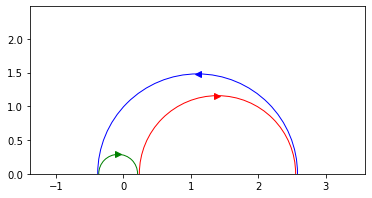

In [40]:
plotPants(([0,1,0,1,1], [1,1,1,0], [0,0,1,0]))

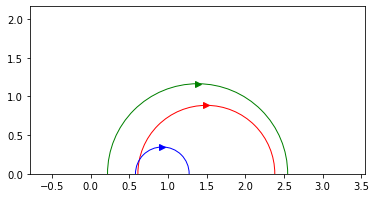

In [41]:
plotPants2(([0,1,1,0,1,0], [0,1,0,1,1],[1,1,1,0,1,0]))